# Generating trading signals with LightGBM and CatBoost

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
YEAR = 252
idx = pd.IndexSlice

In [70]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

## Get Data

In [5]:
data = (pd.read_hdf('../data/us_stocks.h5', 'model_data')
            .sort_index())
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1247456 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1246956 non-null  float64
 1   ret_03       1245956 non-null  float64
 2   ret_05       1244956 non-null  float64
 3   ret_10       1242456 non-null  float64
 4   ret_21       1236956 non-null  float64
 5   ret_42       1226456 non-null  float64
 6   ret_63       1215956 non-null  float64
 7   ret_126      1184456 non-null  float64
 8   ret_252      1121456 non-null  float64
 9   ret_fwd      1247456 non-null  float64
 10  BB_UP        1237956 non-null  float64
 11  BB_LOW       1237956 non-null  float64
 12  BB_SQUEEZE   1237956 non-null  float64
 13  HT           1215956 non-null  float64
 14  SAR          1246956 non-null  float64
 15  ADX          1233956 non-null  float64
 16  ADXR         12274

## Custom Time Series Cross-Validation

In [8]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


## Model Selection: Lookback, lookahead and roll-forward periods

In [9]:
tickers = data.index.get_level_values('ticker').unique()

In [10]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month
data['weekday'] = dates.weekday

In [37]:
target = 'ret_fwd'
features = data.columns.drop(target).tolist()

In [38]:
categoricals = ['year', 'month', 'weekday']

In [44]:
train_length = 3 * 252
test_length = 3 * 21

In [45]:
lookahead = 1

## Baseline: Linear Regression

In [46]:
lr = LinearRegression()

In [49]:
df = pd.get_dummies(data.loc[:, features + [target]].dropna(), 
                    columns=categoricals, 
                    drop_first=True)
X, y = df.drop(target, axis=1), df[target]

n_splits = int(2 * YEAR / test_length)
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

ic, preds = [], []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
    ic.append(spearmanr(y_test, y_pred)[0])
preds = pd.concat(preds)

In [50]:
spearmanr(preds.y_true, preds.y_pred)[0]

0.007516228996712189

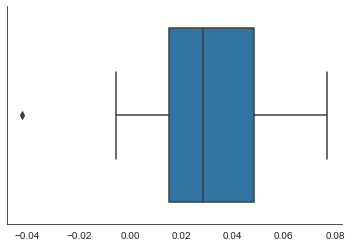

In [54]:
with sns.axes_style('white'):
    sns.boxplot(ic)
    sns.despine();

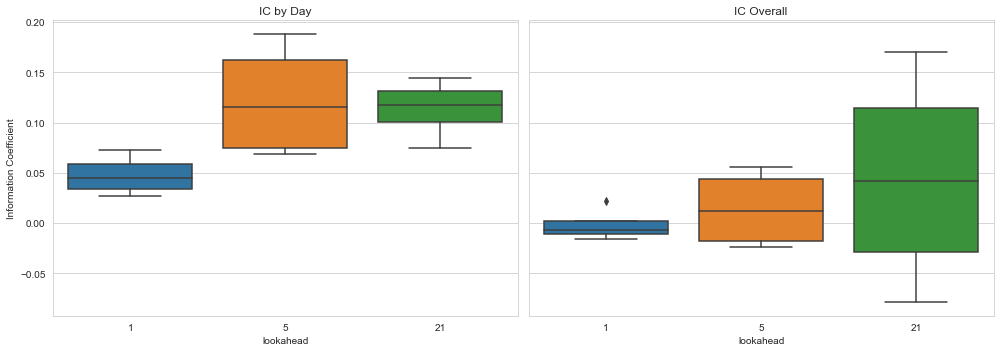

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day', data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic', data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

## LightGBM Model Tuning

In [55]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

In [56]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

In [57]:
learning_rate_ops = [.01, .1, .3]
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
feature_fraction_opts = [.3, .6, .95]
min_data_in_leaf_opts = [250, 500, 1000]

In [58]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [59]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [60]:
train_length = 3 * 252
test_lengths = 63

### Categorical Variables

In [61]:
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [62]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

In [78]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50)) + [750, 1000] + [1500, 2000, 2500]
num_boost_round = num_iterations[-1]

In [79]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [80]:
lgb_store = 'lgb_tuning.h5'

### AlphaLens Analysis

#### Prepare Factor Data

In [ ]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf(results_path / 'predictions.h5', f'lgb/test/{t:02}')
          .drop('y_test', axis=1)
          .iloc[:, :5]
          .mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [ ]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

In [ ]:
factor.head()

#### Select next available trade prices

Using next available prices.

In [ ]:
tickers = factor.index.get_level_values('symbol').unique()

In [ ]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)

In [ ]:
cvp = np.random.choice(list(range(n_params)),
                       size=int(n_params / 4),
                       replace=False)
cv_params_ = [cv_params[i] for i in cvp]

n_splits = int(2 * YEAR / test_length)
print(f'Train: {train_length:3.0f} | '
      f'Test: {test_length:2.0f} | '
      f'Params: {len(cv_params_):3.0f}')

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=lookahead,
                          test_period_length=test_length,
                          train_period_length=train_length)

outcome_data = data.loc[:, features + [target]].dropna()
lgb_data = lgb.Dataset(data=data.drop(target, axis=1),
                       label=data[target],
                       categorical_feature=categoricals,
                       free_raw_data=False)
T = 0
predictions, metrics, daily_ic = [], [], []
for p, param_vals in enumerate(cv_params_):
    key = f'{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
    params = dict(zip(param_names, param_vals))
    params.update(base_params)

    start = time()
    cv_preds, nrounds = [], []
    ic_cv = defaultdict(list)
    for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
        lgb_train = lgb_data.subset(train_idx.tolist()).construct()
        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_round,
                          verbose_eval=False)
        test_set = data.iloc[test_idx, :]
        X_test = test_set.loc[:, model.feature_name()]
        y_test = test_set.loc[:, target]
        y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
        cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
    cv_preds = pd.concat(cv_preds).assign(**params)
    predictions.append(cv_preds)
    by_day = cv_preds.groupby(level='date')
    ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                           for n in num_iterations], axis=1)
    daily_ic_mean = ic_by_day.mean()
    daily_ic_mean_n = daily_ic_mean.idxmax()
    daily_ic_median = ic_by_day.median()
    daily_ic_median_n = daily_ic_median.idxmax()

    ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
    t = time() - start
    T += t
    metrics = pd.Series(list(param_vals) +
                        [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                        index=metric_cols)
    msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
    msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
    msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
    print(msg)

    metrics.to_hdf(lgb_store, 'metrics/' + key)
    ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
    cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Train: 756 | Test: 63 | Params:  27
  0 | 00:03:08 (188) |  0.10 |   8 | 95% |  500 |  29.03% |  8.22% |  2500 |  6.93% |  2500


## Generate LightGBM predictions

### Model Configuration

In [ ]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

categoricals = ['year', 'month', 'sector', 'weekday']

In [ ]:
lookahead = 1

### Get Data

In [ ]:
lgb_data = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

### Generate predictions

In [ ]:
for position in range(10):
    params = get_params(daily_ic_avg,
                    t=lookahead,
                    best=position)
    
    params = params.to_dict()
    
    for p in ['min_data_in_leaf', 'num_leaves']:
        params[p] = int(params[p])
    train_length = int(params.pop('train_length'))
    test_length = int(params.pop('test_length'))
    num_boost_round = int(params.pop('boost_rounds'))
    params.update(base_params)

    print(f'\nPosition: {position:02}')

    n_splits = int(1 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    predictions = []
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(i, end=' ', flush=True)
        lgb_train = lgb_data.subset(train_idx.tolist()).construct()

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_round,
                          verbose_eval=False)

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, label].to_frame('y_test')
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))

    if position == 0:
        test_predictions = (pd.concat(predictions)
                            .rename(columns={'prediction': position}))
    else:
        test_predictions[position] = pd.concat(predictions).prediction

by_day = test_predictions.groupby(level='date')
for position in range(10):
    if position == 0:
        ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
    else:
        ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
print(ic_by_day.describe())
ic_by_day.to_csv(f'ic_by_day_{lookahead:02}.csv')

test_predictions.to_hdf(results_path / 'predictions.h5', f'lgb/test/{lookahead:02}')

### AlphaLens Analysis

#### Prepare Factor Data

In [ ]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf(results_path / 'predictions.h5', f'lgb/test/{t:02}')
          .drop('y_test', axis=1)
          .iloc[:, :5]
          .mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [ ]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

In [ ]:
factor.head()

#### Select next available trade prices

Using next available prices.

In [ ]:
tickers = factor.index.get_level_values('symbol').unique()

In [ ]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)